


The input file contains 12 observations.

ORBITAL ELEMENTS
a = 1.901674 AU
e = 0.129813
i = 19.13874 degrees
omega = 104.169797 degrees
Omega = 176.31079 degrees
E = 0.064247 degrees
M = 0.055907 degrees at JD = 2459040.710386
n = 0.00656 rad/day
JD of last perihelion passage = 2459040.561633
P = 2.624277 yrs

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900

AVERAGE ORBITAL ELEMENTS
a = 1.9016844051428339 AU
e = 0.1298270353579208
i = 19.138787195472077 degrees
omega = 104.15842479905461 degrees
Omega = 176.31167438558293 degrees
E = 0.074169736285220

/Users/fionaluo/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


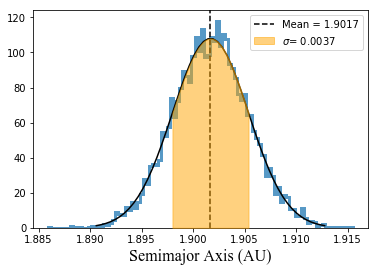

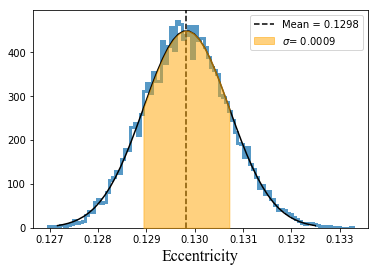

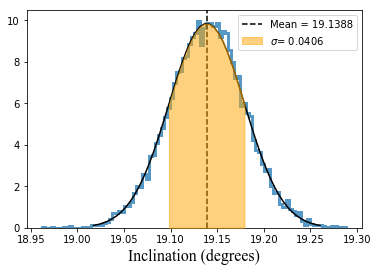

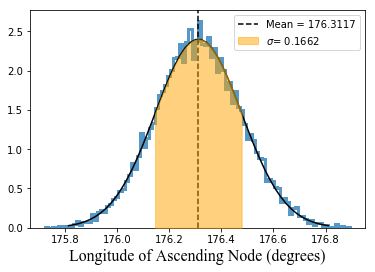

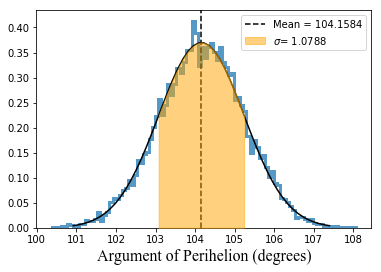

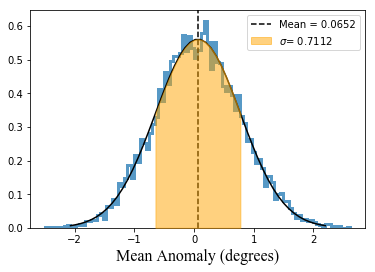

In [5]:
# LuoOD.py
# Fiona Luo, NMT2
# 07/17/2020
# This program implements the Method of Gauss to calculate 6
# orbital elements of an asteroid given 3 initial ra/dec observations. 
# It uses various methods from the library odlib.py, and runs with
# the input file LuoInput.txt. 
# Monte Carlo simulations are used to calculate the uncertainty of the output. 

import odlib as od
import numpy as np
import math
from math import radians, sin, cos, sqrt, pi, degrees, acos, asin
import uncertainty
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# CONSTANTS
gauss = 58.132358929894
k = 0.01720209895 #Gaussian gravitational constant
G = 6.67428 * 10 ** -11 # Gravitational constant
Msun = 1.98892 * 10 ** 30
Mearth = 5.9722 * 10 ** 24
cAU = 173.144632674240 #speed of light in au/(mean solar)day 
eps = math.radians(23.4366) #Earth's obliquity

def main():
    # READ INPUT FILE
    filename = "LuoInput.txt"
    corrfiles = ["corr.fits", "corr2.fits", "corr3a.fits"]
    odicts, exdicts = readallinput(filename) # read and print input file, ask user for observation #'s
    edict = getorbitalelements(odicts, exdicts) # get orbital elements
    
    # PRINT ORBITAL ELEMENTS
    od.printorbitalelements(edict)
    print()

    # Monte Carlo: iterate through many cases and reset the ra and dec
    avg_elements, std_elements, sdom_elements = getuncertainties(odicts, corrfiles, edict, iteration = 10000, printresults = True)


# Input: odicts (list of dictionaries for each observation's JD, Ra, Dec, X, Y, Z)
# Output: Orbital elements a, e, i, w, Omega, M, E, n, lastper, P
def getorbitalelements(odicts, exdicts = []):
    # Calculate taus (pg 25 in od report)
    t1 = odicts[0]["jd"]
    t2 = odicts[1]["jd"]
    t3 = odicts[2]["jd"]
    tau3 = k * (t3 - t2)
    tau1 = k * (t1 - t2)
    tau = k * (t3 - t1)
    taus = [tau1, tau3, tau] # [tau1, tau3, tau]
    
    # Calculate rhohats (NUMPY ARRAYS)
    phat1 = od.getrhohat(odicts[0]["ra"], odicts[0]["dec"])
    phat2 = od.getrhohat(odicts[1]["ra"], odicts[1]["dec"])
    phat3 = od.getrhohat(odicts[2]["ra"], odicts[2]["dec"])
    
    # Get sun vectors
    R1 = odicts[0]["R"]
    R2 = odicts[1]["R"]
    R3 = odicts[2]["R"]

    # Calculate D's
    D0 = np.dot(phat1, np.cross(phat2, phat3))
    D11 = np.dot(np.cross(R1, phat2), phat3)
    D12 = np.dot(np.cross(R2, phat2), phat3)
    D13 = np.dot(np.cross(R3, phat2), phat3)
    D21 = np.dot(np.cross(phat1, R1), phat3)
    D22 = np.dot(np.cross(phat1, R2), phat3)
    D23 = np.dot(np.cross(phat1, R3), phat3)
    D31 = np.dot(phat1, np.cross(phat2, R1))
    D32 = np.dot(phat1, np.cross(phat2, R2))
    D33 = np.dot(phat1, np.cross(phat2, R3))
    Ds = [D0, D21, D22, D23]

    # Calculate r2 from SEL
    roots, rhos = od.SEL(taus, R2.tolist(), phat2, Ds)
    r2 = 0

    viableroots = [] # contains INDECES of the viable roots from 0 to len(roots) - 1
    for i in range(len(roots)):
        if roots[i] > 0 and rhos[i] > 0:
            viableroots.append(i)
    # If there are multiple positive real roots, ask the user which to use
    if (len(viableroots) > 1):
        n = len(viableroots) # Hardcoded for now
        '''for i in range(len(viableroots)):
            print(roots[viableroots[i]], end = " ")
            print("RHOS", rhos[viableroots[i]], end = " ")
        print()'''
        r2 = roots[viableroots[n-1]]
        rho = rhos[viableroots[n-1]]
    # If there's only one root, use that one
    elif len(viableroots) == 1:
        r2 = roots[viableroots[0]]
        rho = rhos[viableroots[0]]
    else:
        #print("No SEL Solution")
        return {}
    
    # Get initial estimates for f and g in the second order
    # Put array of zeroes for r2dot since we don't know it yet and don't use it in the method
    empty = [0,0,0]
    flag = 2
    f1,g1 = od.fg(tau1,r2,empty,flag) 
    f3,g3 = od.fg(tau3,r2,empty,flag)

    # Calculate c's and d's, get initial r2dot value
    c1 = g3 / (f1*g3 - g1*f3)
    c3 = -1*g1 / (f1*g3 - g1*f3)
    c2 = -1
    d1 = -1 * f3 / (f1*g3 - f3*g1)
    d3 = f1 / (f1*g3 - f3*g1)

    # Calculate rhos (magnitudes), equation 101
    rho1m = (c1*D11 + c2*D12 + c3*D13) / (c1*D0)
    rho2m = (c1*D21 + c2*D22 + c3*D23) / (c2*D0)
    rho3m = (c1*D31 + c2*D32 + c3*D33) / (c3*D0)
    # Calculate rho vectors by multiplying rho magnitudes by phats
    rho1 = phat1 * rho1m
    rho2 = phat2 * rho2m
    rho3 = phat3 * rho3m
    
    # Get r1, r3, with equation 2, r2dot with equation 105
    r1 = rho1 - R1
    r2 = rho2 - R2
    r3 = rho3 - R3
    r2dot = d1*r1 + d3*r3

    # MAIN ITERATION LOOP
    diff = 100
    fnew, gnew = 0, 0
    iteration = 1
    lighttraveltime = 0
    while diff > 10 ** -12:
    #for i in range (1):
        # Account for light travel time
        # Calculate new times = toriginal - momentum magnitude / speed of light
        t1n = t1 - rho1m / cAU
        t2n = t2 - rho2m / cAU
        t3n = t3 - rho3m / cAU
        # Calculate new taus
        tau3 = k * (t3n - t2n)
        tau1 = k * (t1n - t2n)
        tau = k * (t3n - t1n)
        taus = [tau1, tau3, tau] # [tau1, tau3, tau]

        # Calculate new f and g values
        f1, g1 = od.fg(tau1, r2, r2dot, 0)
        f3, g3 = od.fg(tau3, r2, r2dot, 0)

        # Calculate c's and d's, get initial r2dot value
        c1 = g3 / (f1*g3 - g1*f3)
        c3 = -1*g1 / (f1*g3 - g1*f3)
        c2 = -1
        d1 = -1 * f3 / (f1*g3 - f3*g1)
        d3 = f1 / (f1*g3 - f3*g1)

        # Calculate rhos (magnitudes), equation 101
        rho1m = (c1*D11 + c2*D12 + c3*D13) / (c1*D0)
        rho2m = (c1*D21 + c2*D22 + c3*D23) / (c2*D0)
        rho3m = (c1*D31 + c2*D32 + c3*D33) / (c3*D0)
        # Calculate rho vectors by multiplying rho magnitudes by phats
        rho1 = phat1 * rho1m
        rho2new = phat2 * rho2m
        rho3 = phat3 * rho3m
        
        # Get r1, r3, with equation 2, r2dot with equation 105
        r1 = rho1 - R1
        r2 = rho2new - R2
        r3 = rho3 - R3
        r2dot = d1*r1 + d3*r3
        # Calculate light travel time
        lighttraveltime = rho2m / cAU * 24 * 60 * 60

        diff = abs(np.linalg.norm(rho2new) - np.linalg.norm(rho2))
        rho2 = rho2new
        iteration += 1

        if iteration > 200:
            break

    #I", r2, r2dot)
    # Convert r2 and r2dot from equatorial to ECLIPTIC coordinates
    m1 = np.array([[1,0,0],[0,cos(eps),-1*sin(eps)],[0,sin(eps),cos(eps)]])
    m1 = np.linalg.inv(m1)
    r2ec = np.dot(m1, r2)
    r2dotec = np.dot(m1, r2dot)

    jdcorrected = odicts[1]["jd"] # jd with light travel time correction
    newdate = "2020-Jul-25"
    newtime = "16:00:00"
    jdnew = od.juliandate(newdate, newtime)
    
    # CALCULATE ORBITAL ELEMENTS
    edict = od.orbitalelements(r2ec, r2dotec, jdcorrected)
    return edict


# Reads/prints the input file, stores it in an array of dictionaries for each observation
# Asks the user which observations they would like to use
# Returns list of the chosen observations
def readallinput(filename):
    # read in the input file and store it in an array of dictionaries
    odictsraw = od.readodfile(filename)

    # If there are more than 3 observations, ask the user which observations they would like to 
    # use (Format: 1 2 3)
    odicts = odictsraw # the final chosen observations
    exdicts = []
    
    if len(odictsraw) > 3:
        
        print("\nThe input file contains {0} observations.".format(len(odictsraw)))
        
        chosen = 1, 2, 3
        chosen = sorted(chosen)
        # Create a new list of chosen observations, stored in element dictionaries
        odicts = []
        exdicts = [] #Store unused observations in extra dicts for differential correction
        for n in range(1, len(odictsraw) + 1):
            if n in chosen:
                odicts.append(odictsraw[n - 1])
            else:
                exdicts.append(odictsraw[n - 1])
    
    return odicts, exdicts


# Input: odicts (observation), corrfiles [corr1.fits, corr2.fits, corr3.fits], edicts (final elements)
# Output: avg_elements, std_elements, sdom_elements
# This function uses a random Monte Carlo simulation to find the average values and uncertainties of 
# orbital elements. 
def getuncertainties(odicts, corrfiles, edict, iteration = 10000, printresults = True):
    # Uncertainties in ra and dec for observations 1, 2, 3
    ura1, udec1 = uncertainty.rmsradec(corrfiles[0], radians = True)
    ura2, udec2 = uncertainty.rmsradec(corrfiles[1], radians = True)
    ura3, udec3 = uncertainty.rmsradec(corrfiles[2], radians = True)
    # Dictionary of lists of the randomly generated values for each element
    flux_edicts = {}
    elementnames = ["a", "e", "i", "w", "Omega", "M", "E", "n", "lastper", "P"] # Labels/keys for elements
    # Initiatize flux_edicts with empty lists
    for i in range(len(elementnames)):
        flux_edicts[elementnames[i]] = []

    iterations = 0 # The number iteration we are on in the loop
    for i in range(iteration):
        if i%100 == 0:
            print(i)
        #print(i)
        odictsnew = [i.copy() for i in odicts] # The dictionary with modified ra and dec values
        # New dictionary of observations; change the 6 ras and decs randomly
        odictsnew[0]["ra"] = np.random.normal(odicts[0]["ra"], ura1)
        odictsnew[1]["ra"] = np.random.normal(odicts[1]["ra"], ura2)
        odictsnew[2]["ra"] = np.random.normal(odicts[2]["ra"], ura3)
        odictsnew[0]["dec"] = np.random.normal(odicts[0]["dec"], udec1)
        odictsnew[1]["dec"] = np.random.normal(odicts[1]["dec"], udec2)
        odictsnew[2]["dec"] = np.random.normal(odicts[2]["dec"], udec3)
        # get new orbital elements (could be empty array if there's an error)
        edictnew = getorbitalelements(odictsnew)
        
        iterations += 1
        # If getting edict/elements were successful
        if edictnew != {}:
            for i in range(len(elementnames)): # append elements to flux_edicts
                element = elementnames[i]
                flux_edicts[element].append( edictnew[element] )
        else: #otherwise, discount the iteration
            iterations -= 1

    # Find mean, standard deviation, sdom 
    avg_elements = {}
    std_elements = {}
    sdom_elements = {}
    for i in range(len(elementnames)): #for each element
        element = elementnames[i]
        avg_elements[element] = np.average(flux_edicts[element])
        std_elements[element] = np.std(flux_edicts[element])
    for i in range(len(std_elements)): #for each element
        element = elementnames[i]
        sdom_elements[element] = std_elements[element] / (iterations) ** 0.5


    # PRINT average, std, sdoms
    if printresults:
        od.printuncertainties(avg_elements, std_elements, sdom_elements)

    # print HISTOGRAMS
    orbitalelements = ["a", "e", "i", "Omega", "w", "M"]
    titles = ["Semimajor Axis (AU)", "Eccentricity", "Inclination (degrees)", \
        "Longitude of Ascending Node (degrees)", "Argument of Perihelion (degrees)", "Mean Anomaly (degrees)"]
    
    for i in range(len(orbitalelements)): #for each element
        
        fig, ax = plt.subplots(1,1)
        element = orbitalelements[i]
        # example by Devin Whitten
        # Set up a normal distribution with mean=5.0 and std=1.5, 500 samples
        mean = avg_elements[element]
        std = std_elements[element]
        omega1 = flux_edicts[element]

        # We can plot the function form of the gaussian over the histogram too
        # Looks nice and is a sanity check for the mean and std
        def gaussian(x, a, mean, std):
            return 1./(np.sqrt(np.pi * 2) * std)*np.exp(-(x-mean)**2/(2*std**2))


        # A basic histogram of the distribution
        ax.hist(omega1, alpha=0.75, bins = 100, zorder=2, histtype="step", linewidth=3, normed=True)

        # Let's put a vertical line at the mean of the distribution with the label "Mean = ..."
        ax.axvline(np.mean(omega1), color="black", linestyle="--", label="Mean = " + "%.4F" % np.mean(omega1))

        # Some information about the standard deviation would be very informative
        span = np.linspace(mean - std, mean + std, 50)  # the range of mean +/- std
        #xrange = np.linspace(0,10,50) # the full xspan of the plot
        mi = mean - 3 * std
        ma = mean + 3 * std
        xrange = np.linspace(mi, ma)
        
        # Plot the functional form of the gaussian
        ax.plot(xrange, gaussian(xrange, None, mean, std), color="black")

        # Fill in the 1 sigma range with color
        plt.fill_between(span, np.zeros(50), gaussian(span, None, mean, std),
                         alpha=0.50, color="orange", zorder=3, label = r"$\sigma$= %.4F" % std)

        #plt.xlabel(r"$\Omega$", fontname="Times New Roman", fontsize=16)
        plt.xlabel(titles[i], fontname="Times New Roman", fontsize=16)
        
        # Legend just displays the labels
        plt.legend()
        plt.show()

    return avg_elements, std_elements, sdom_elements


# Run the main method
print("\n")
main()
print("\n")
